In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout

In [9]:
# Path dataset
train_path = "train/train/"
test_path = "test/test/"


In [10]:
# List file
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(f"Jumlah file train: {len(train_files)}")
print(f"Jumlah file test: {len(test_files)}")

Jumlah file train: 4257
Jumlah file test: 2057


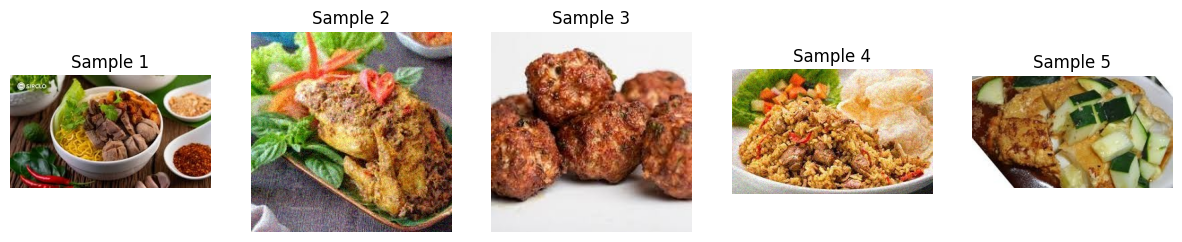

In [11]:
# Tampilkan sample gambar
def show_sample_images(num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img_path = os.path.join(train_path, train_files[i])
        img = image.load_img(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")
    plt.show()

show_sample_images()

In [12]:
# Load pre-trained model untuk ekstraksi fitur
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    """Ekstrak fitur dari gambar menggunakan MobileNetV2"""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = feature_extractor.predict(x, verbose=0)
    return features.flatten()

C:\Users\andri\AppData\Local\Temp\ipykernel_2908\874850285.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


In [13]:
# Ekstrak fitur untuk semua gambar train
print("Memulai ekstraksi fitur dari gambar train...")
train_features = []
for i, file in enumerate(train_files):
    if i % 100 == 0:
        print(f"Proses: {i}/{len(train_files)}")
    features = extract_features(os.path.join(train_path, file))
    train_features.append(features)

train_features = np.array(train_features)
print(f"Shape fitur train: {train_features.shape}")

Memulai ekstraksi fitur dari gambar train...
Proses: 0/4257
Proses: 100/4257
Proses: 200/4257
Proses: 300/4257
Proses: 400/4257
Proses: 500/4257
Proses: 600/4257
Proses: 700/4257
Proses: 800/4257
Proses: 900/4257
Proses: 1000/4257
Proses: 1100/4257
Proses: 1200/4257
Proses: 1300/4257
Proses: 1400/4257
Proses: 1500/4257
Proses: 1600/4257
Proses: 1700/4257
Proses: 1800/4257
Proses: 1900/4257
Proses: 2000/4257
Proses: 2100/4257
Proses: 2200/4257
Proses: 2300/4257
Proses: 2400/4257
Proses: 2500/4257
Proses: 2600/4257
Proses: 2700/4257
Proses: 2800/4257
Proses: 2900/4257
Proses: 3000/4257
Proses: 3100/4257
Proses: 3200/4257
Proses: 3300/4257
Proses: 3400/4257
Proses: 3500/4257
Proses: 3600/4257
Proses: 3700/4257
Proses: 3800/4257
Proses: 3900/4257
Proses: 4000/4257
Proses: 4100/4257
Proses: 4200/4257
Shape fitur train: (4257, 1280)


In [14]:
# Daftar 15 makanan tradisional Indonesia
label_names = [
    "Ayam Bakar", "Ayam Betutu", "Ayam Goreng", "Ayam Pop", "Bakso",
    "Coto Makassar", "Gado Gado", "Gudeg", "Nasi Goreng", "Pempek",
    "Rawon", "Rendang", "Sate Madura", "Sate Padang", "Soto"
]

In [15]:
# Clustering dengan K-Means
print("Memulai proses clustering...")
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(train_features)

Memulai proses clustering...


In [16]:
# Analisis hasil clustering
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Distribusi cluster:")
print(cluster_counts)

Distribusi cluster:
0     402
1     334
2      40
3     269
4     335
5     272
6     127
7     332
8     299
9     246
10    276
11    160
12    509
13    275
14    381
Name: count, dtype: int64


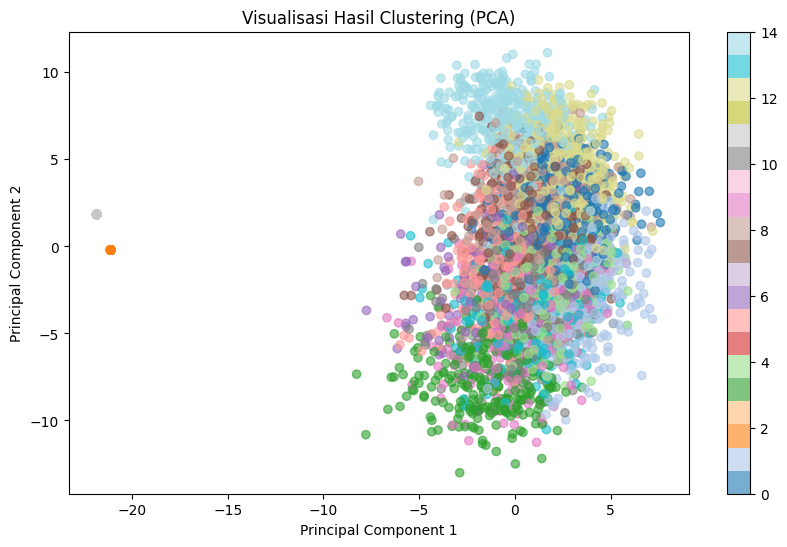

In [17]:
# Visualisasi clustering (menggunakan PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(train_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='tab20', alpha=0.6)
plt.colorbar(scatter)
plt.title('Visualisasi Hasil Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [18]:
# Buat DataFrame untuk data train
train_df = pd.DataFrame({
    'filename': train_files,
    'cluster': cluster_labels
})

# Beri nama label berdasarkan cluster (ini akan disesuaikan manual nanti)
# Untuk sementara, kita mapping cluster ke label names
train_df['label'] = train_df['cluster'].apply(lambda x: label_names[x % len(label_names)])

# Label Encoder
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])

print("Sample data train:")
print(train_df.head())

print("\nMapping label:")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

Sample data train:
     filename  cluster        label  label_encoded
0  001g4d.jpg        0   Ayam Bakar              0
1  004v2b.jpg       13  Sate Padang             13
2  00ae48.jpg        4        Bakso              4
3  00sv9l.jpg        7        Gudeg              7
4  012nt0.jpg        1  Ayam Betutu              1

Mapping label:
0: Ayam Bakar
1: Ayam Betutu
2: Ayam Goreng
3: Ayam Pop
4: Bakso
5: Coto Makassar
6: Gado Gado
7: Gudeg
8: Nasi Goreng
9: Pempek
10: Rawon
11: Rendang
12: Sate Madura
13: Sate Padang
14: Soto


In [19]:
# Split data untuk training dan validation
X = train_features
y = train_df['label_encoded'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data train: {X_train.shape}, Data validation: {X_val.shape}")

Data train: (3405, 1280), Data validation: (852, 1280)


In [20]:
# Bangun model neural network
feature_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(label_names), activation='softmax')
])

feature_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


c:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Callback untuk early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model
print("Memulai training model...")
history = feature_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Memulai training model...
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3718 - loss: 1.8765 - val_accuracy: 0.7582 - val_loss: 0.7845
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6526 - loss: 1.0062 - val_accuracy: 0.8404 - val_loss: 0.4945
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7571 - loss: 0.7182 - val_accuracy: 0.8110 - val_loss: 0.4855
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7900 - loss: 0.6301 - val_accuracy: 0.8404 - val_loss: 0.4443
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8223 - loss: 0.5133 - val_accuracy: 0.8322 - val_loss: 0.4351
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8443 - loss: 0.4798 - val_accuracy: 0.8556 - val_loss: 0.3693
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8614 - loss: 0.4116 - val_accuracy: 0.8392 - val_loss: 0.4513
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8708 - loss:

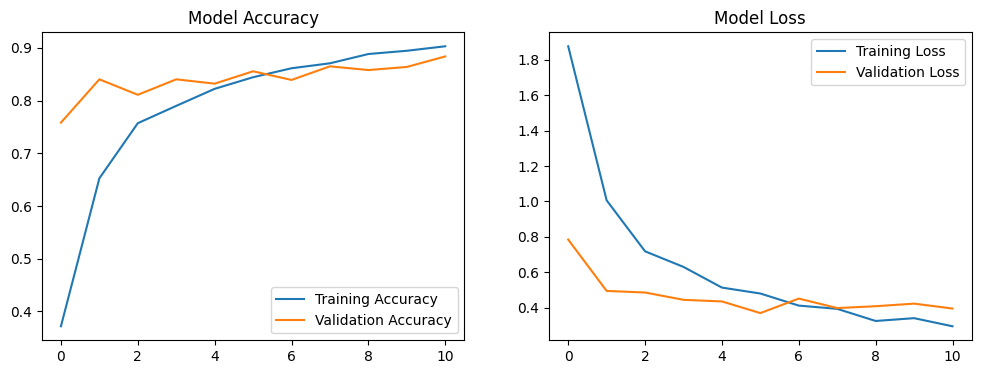

In [22]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [23]:
# Simpan semua model dan encoder
feature_model.save('food_classifier_model.h5')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
feature_extractor.save('feature_extractor.h5')

print("Semua model berhasil disimpan!")
print("✓ food_classifier_model.h5")
print("✓ label_encoder.pkl") 
print("✓ kmeans_model.pkl")
print("✓ feature_extractor.h5")

Semua model berhasil disimpan!
✓ food_classifier_model.h5
✓ label_encoder.pkl
✓ kmeans_model.pkl
✓ feature_extractor.h5


In [27]:
# Baca file test.csv
test_df = pd.read_csv("test.csv")
print(f"Data test: {test_df.shape}")

# Dapatkan semua file yang ada di folder test
actual_test_files = os.listdir(test_path)
print(f"File di folder test: {len(actual_test_files)}")

# Buat list file yang akan diproses (urut berdasarkan ID)
test_files = []
for id_val in test_df['ID']:
    # Cari file yang mengandung ID (dengan leading zeros)
    id_pattern = f"{id_val:04d}"
    matching_files = [f for f in actual_test_files if f.startswith(id_pattern)]
    
    if matching_files:
        test_files.append(matching_files[0])
    else:
        # Coba tanpa leading zeros
        id_pattern2 = str(id_val)
        matching_files2 = [f for f in actual_test_files if f.split('.')[0].lstrip('0') == id_pattern2]
        if matching_files2:
            test_files.append(matching_files2[0])
        else:
            print(f"❌ File untuk ID {id_val} tidak ditemukan")
            test_files.append(None)

# Prediksi
predictions = []
print("Memulai prediksi...")

for i, file in enumerate(test_files):
    if i % 100 == 0:
        print(f"Proses: {i}/{len(test_files)}")
    
    if file is None:
        predictions.append("Nasi Goreng")
        continue
        
    img_path = os.path.join(test_path, file)
    
    try:
        features = extract_features(img_path)
        pred = feature_model.predict(np.expand_dims(features, axis=0), verbose=0)
        label_idx = np.argmax(pred)
        label_name = le.inverse_transform([label_idx])[0]
        predictions.append(label_name)
    except:
        predictions.append("Nasi Goreng")

test_df['label'] = predictions
test_df.to_csv("submission.csv", index=False)

print("✅ Selesai!")
print(test_df.head())

Data test: (2057, 2)
File di folder test: 2057
Memulai prediksi...
Proses: 0/2057
Proses: 100/2057
Proses: 200/2057
Proses: 300/2057
Proses: 400/2057
Proses: 500/2057
Proses: 600/2057
Proses: 700/2057
Proses: 800/2057
Proses: 900/2057
Proses: 1000/2057
Proses: 1100/2057
Proses: 1200/2057
Proses: 1300/2057
Proses: 1400/2057
Proses: 1500/2057
Proses: 1600/2057
Proses: 1700/2057
Proses: 1800/2057
Proses: 1900/2057
Proses: 2000/2057
✅ Selesai!
   ID        label
0   1        Rawon
1   2   Ayam Bakar
2   3        Bakso
3   4  Ayam Betutu
4   5  Sate Madura


In [28]:
# Validasi final submission
print("🔍 Validasi Submission File:")
print(f"Total rows: {len(test_df)}")
print(f"Unique labels: {test_df['label'].nunique()}")
print(f"Label categories: {sorted(test_df['label'].unique())}")

# Cek apakah ada missing values
if test_df['label'].isnull().any():
    print("⚠️  Ada missing values dalam prediksi!")
    test_df['label'] = test_df['label'].fillna("Nasi Goreng")

# Simpan final submission
test_df[['ID', 'label']].to_csv("submission.csv", index=False)
print("🎉 File submission.csv siap untuk diupload ke Kaggle!")

🔍 Validasi Submission File:
Total rows: 2057
Unique labels: 13
Label categories: ['Ayam Bakar', 'Ayam Betutu', 'Ayam Pop', 'Bakso', 'Coto Makassar', 'Gado Gado', 'Gudeg', 'Nasi Goreng', 'Pempek', 'Rawon', 'Sate Madura', 'Sate Padang', 'Soto']
🎉 File submission.csv siap untuk diupload ke Kaggle!


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation Accuracy: 0.8556


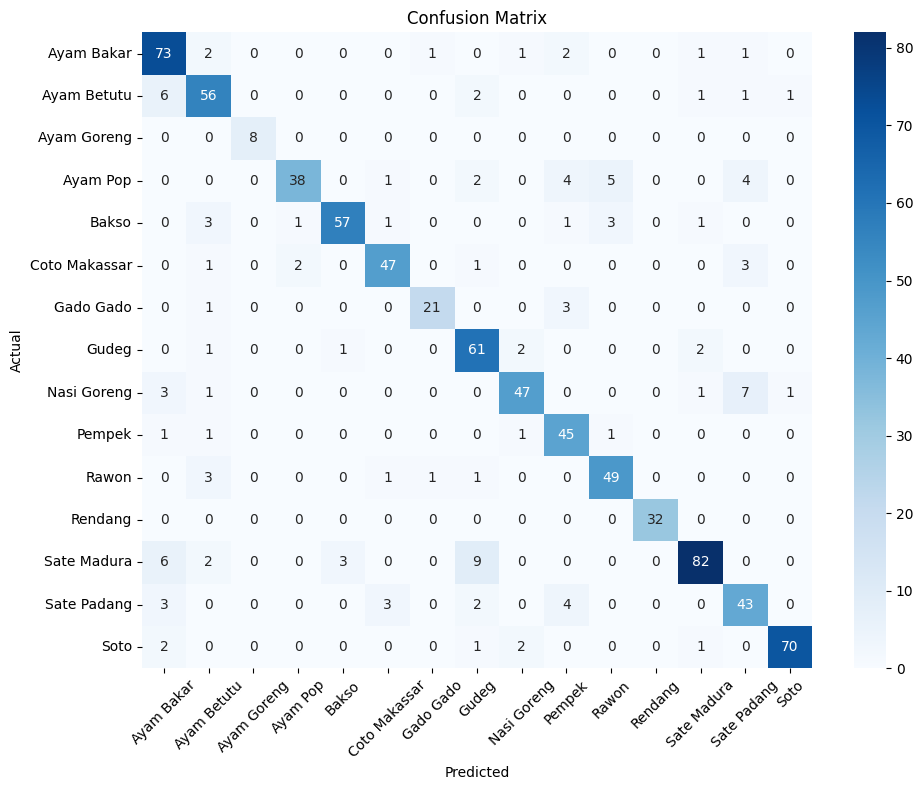

In [29]:
# Evaluasi pada validation set
y_val_pred = feature_model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

val_accuracy = accuracy_score(y_val, y_val_pred_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()